**ECG Time-Series Forecasting with Multiple Deep Neural Network Models**

Setup and Installation
This cell installs the required packages for the ECG time series forecasting project.

In [ ]:
# Install required packages for Excel file reading
!pip install xlrd

  Using cached xlrd-2.0.1-py2.py3-none-any.whl.metadata (3.4 kB)
Using cached xlrd-2.0.1-py2.py3-none-any.whl (96 kB)


In [ ]:
# Install PyTorch Lightning for simplified deep learning workflows
!pip install pytorch-lightning

  Using cached pytorch_lightning-2.5.0.post0-py3-none-any.whl.metadata (21 kB)
  Using cached torch-2.6.0-cp312-cp312-win_amd64.whl.metadata (28 kB)
  Using cached fsspec-2025.2.0-py3-none-any.whl.metadata (11 kB)
  Using cached torchmetrics-1.6.1-py3-none-any.whl.metadata (21 kB)
  Using cached lightning_utilities-0.12.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached aiohttp-3.11.12-cp312-cp312-win_amd64.whl.metadata (8.0 kB)
  Using cached filelock-3.17.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached numpy-2.2.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached aiohappyeyeballs-2.4.6-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached frozenlist-1.5.0-cp312-cp312-win_amd64.whl.metadata (14 kB)
  Using cached multidi

In [ ]:
# Install seaborn for statistical data visualization
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.10.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp312-cp312-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp312-cp312-win_amd64.whl.metadata (103 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached matplotlib-3.10.0-cp312-cp312-win_amd64.whl (8.0 MB)
Using cached contourpy-1.3.1-cp312-cp312-win_amd64.whl (220 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.56.0-cp312-cp312-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl (71 kB)
Using cached pyparsing-3.2.1-py3-none-any.whl (107 kB)


In [ ]:
# Install scikit-learn for machine learning utilities and metrics
!pip install scikit-learn

  Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl.metadata (15 kB)
  Using cached scipy-1.15.2-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl (11.1 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.15.2-cp312-cp312-win_amd64.whl (40.9 MB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)


**Import Libraries**

This cell imports all necessary libraries for data processing, modeling, and visualization.

In [ ]:
import os  # Operating system interface for file operations
import numpy as np  # Numerical computing library
import pandas as pd  # Data manipulation and analysis library
import torch  # PyTorch deep learning framework
import gc  # Garbage collector for memory management
import pytorch_lightning as pl  # High-level PyTorch wrapper
from torch import nn, optim  # Neural network modules and optimizers
from torch.utils.data import DataLoader, TensorDataset, random_split  # Data loading utilities
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Evaluation metrics
from sklearn.preprocessing import MinMaxScaler  # Data normalization
from pytorch_lightning.callbacks import EarlyStopping  # Training callback for early stopping
import json  # JSON file handling
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns  # Statistical data visualization

**Load Previous Results (Skip List)**

This cell loads previously computed results to avoid recomputing the same model configurations.


In [ ]:
# Load previous results if they exist
skip_list_file = "skip_list.json"  # Define the filename for storing completed runs
try:
    # Attempt to open and load the skip list from JSON file
    with open(skip_list_file, "r") as f:
        skip_list = json.load(f)  # Load the JSON data into skip_list dictionary
except (FileNotFoundError, json.JSONDecodeError):
    # If file doesn't exist or is corrupted, initialize empty dictionary
    skip_list = {}

**Data Preprocessing Function**

This cell defines a comprehensive data preprocessing function that loads Excel data, handles missing values, normalizes data, and creates sequences for time series modeling.

In [ ]:
# Data Preprocessing
def load_and_preprocess_data(file_path="p_1.xlsx", input_size=10, output_size=1, val_size=0.2, test_size=0.2):
    """
    Load and preprocess time series data for neural network training
    
    Args:
        file_path: Path to Excel file containing time series data
        input_size: Number of time steps to use as input
        output_size: Number of time steps to predict
        val_size: Proportion of data for validation
        test_size: Proportion of data for testing
    """
    # Load the dataset from Excel file
    df = pd.read_excel(file_path)
    
    # Convert 'Datetime' column to datetime format, handling errors gracefully
    df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
    
    # Convert 'ii' column to numeric format, handling errors gracefully
    df['ii'] = pd.to_numeric(df['ii'], errors='coerce')
    
    # Forward fill missing values in 'ii' column
    df['ii'].fillna(method='ffill', inplace=True)
    
    # Initialize MinMax scaler to normalize data between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # Fit and transform the 'ii' column using the scaler
    df['ii'] = scaler.fit_transform(df[['ii']])

    # Extract the normalized values as numpy array
    data = df['ii'].values
    
    # Initialize lists to store input sequences and corresponding labels
    sequences, labels = [], []
    
    # Create sliding window sequences for time series modeling
    for i in range(len(data) - input_size - output_size + 1):
        # Extract input sequence of length input_size
        sequences.append(data[i:i + input_size])
        # Extract corresponding output sequence of length output_size
        labels.append(data[i + input_size:i + input_size + output_size])

    # Convert lists to numpy arrays for efficient processing
    sequences, labels = np.array(sequences), np.array(labels)
    
    # Calculate training set size (60% of total data)
    train_size = int(len(sequences) * 0.6)
    
    # Calculate validation set size based on val_size parameter
    val_size = int(len(sequences) * val_size)

    # Split data into training, validation, and test sets
    return (sequences[:train_size], labels[:train_size],  # Training data
            sequences[train_size:train_size+val_size], labels[train_size:train_size+val_size],  # Validation data
            sequences[train_size+val_size:], labels[train_size+val_size:], scaler)  # Test data and scaler

**Base Model Class**

This cell defines the base PyTorch Lightning model class that provides common functionality for all neural network models.

In [ ]:
# PyTorch Base Model
class BaseModel(pl.LightningModule):
    """
    Base class for all neural network models using PyTorch Lightning
    Provides common functionality like optimizer configuration and validation steps
    """
    def __init__(self, input_size, output_size):
        """Initialize base model with input and output dimensions"""
        super().__init__()  # Call parent class constructor
        self.input_size = input_size  # Store input sequence length
        self.output_size = output_size  # Store output sequence length

    def configure_optimizers(self):
        """Configure optimizer and learning rate scheduler"""
        # Initialize Adam optimizer with learning rate of 0.001
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Initialize step learning rate scheduler (reduces LR every 10 epochs by factor of 0.9)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
        return [optimizer], [scheduler]  # Return optimizer and scheduler

    def validation_step(self, batch, batch_idx):
        """Perform validation step during training"""
        x, y = batch  # Unpack input and target from batch
        y_hat = self(x)  # Forward pass through model
        loss = nn.MSELoss()(y_hat, y)  # Calculate mean squared error loss
        self.log('val_loss', loss, prog_bar=True)  # Log validation loss

    def test_step(self, batch, batch_idx):
        """Perform test step for model evaluation"""
        x, y = batch  # Unpack input and target from batch
        y_hat = self(x)  # Forward pass through model
        loss = nn.MSELoss()(y_hat, y)  # Calculate mean squared error loss
        self.log('test_loss', loss, prog_bar=True)  # Log test loss

**Chronos Model**

This cell defines the Chronos model, which uses LSTM layers with dropout for time series forecasting.

In [ ]:
# Chronos Models
class ChronosModel(BaseModel):
    """
    Chronos model using LSTM layers with dropout regularization
    Designed for robust time series forecasting
    """
    def __init__(self, input_size, output_size, n_hidden=64, n_layers=3, dropout=0.2):
        """Initialize Chronos model with LSTM architecture"""
        super().__init__(input_size, output_size)  # Call base class constructor
        
        # Define LSTM layer with specified parameters
        self.lstm = nn.LSTM(input_size=1,  # Each time step has 1 feature
                           hidden_size=n_hidden,  # Number of hidden units
                           num_layers=n_layers,  # Number of LSTM layers
                           batch_first=True,  # Batch dimension comes first
                           dropout=dropout)  # Dropout rate for regularization
        
        # Define output layer to map LSTM output to desired output size
        self.fc_out = nn.Linear(n_hidden, output_size)

    def forward(self, x):
        """Forward pass through the model"""
        # Add feature dimension to input (batch_size, seq_len, 1)
        lstm_out, _ = self.lstm(x.unsqueeze(-1))
        # Apply output layer to the last time step's output
        return self.fc_out(lstm_out[:, -1, :])

    def training_step(self, batch, batch_idx):
        """Perform training step"""
        x, y = batch  # Unpack input and target
        y_hat = self(x)  # Forward pass
        loss = nn.MSELoss()(y_hat, y)  # Calculate loss
        self.log('train_loss', loss)  # Log training loss
        return loss  # Return loss for backpropagation

**Moirai Model**

This cell defines the Moirai model, which uses GRU (Gated Recurrent Unit) layers for time series forecasting.

In [ ]:
class MoiraiModel(BaseModel):
    """
    Moirai model using GRU layers
    GRU is computationally more efficient than LSTM while maintaining good performance
    """
    def __init__(self, input_size, output_size, n_hidden=64, n_layers=3):
        """Initialize Moirai model with GRU architecture"""
        super().__init__(input_size, output_size)  # Call base class constructor
        
        # Define GRU layer with specified parameters
        self.gru = nn.GRU(input_size=1,  # Each time step has 1 feature
                         hidden_size=n_hidden,  # Number of hidden units
                         num_layers=n_layers,  # Number of GRU layers
                         batch_first=True)  # Batch dimension comes first
        
        # Define output layer to map GRU output to desired output size
        self.fc_out = nn.Linear(n_hidden, output_size)

    def forward(self, x):
        """Forward pass through the model"""
        # Add feature dimension to input (batch_size, seq_len, 1)
        gru_out, _ = self.gru(x.unsqueeze(-1))
        # Apply output layer to the last time step's output
        return self.fc_out(gru_out[:, -1, :])

    def training_step(self, batch, batch_idx):
        """Perform training step"""
        x, y = batch  # Unpack input and target
        y_hat = self(x)  # Forward pass
        loss = nn.MSELoss()(y_hat, y)  # Calculate loss
        self.log('train_loss', loss)  # Log training loss
        return loss  # Return loss for backpropagation

**TimeGPT Model**

This cell defines the TimeGPT model, another LSTM-based architecture for time series forecasting.

In [ ]:
class TimeGPTModel(BaseModel):
    """
    TimeGPT model using LSTM layers
    Similar to Chronos but without dropout regularization
    """
    def __init__(self, input_size, output_size, n_hidden=64, n_layers=3):
        """Initialize TimeGPT model with LSTM architecture"""
        super().__init__(input_size, output_size)  # Call base class constructor
        
        # Define LSTM layer with specified parameters
        self.lstm = nn.LSTM(input_size=1,  # Each time step has 1 feature
                           hidden_size=n_hidden,  # Number of hidden units
                           num_layers=n_layers,  # Number of LSTM layers
                           batch_first=True)  # Batch dimension comes first
        
        # Define output layer to map LSTM output to desired output size
        self.fc_out = nn.Linear(n_hidden, output_size)

    def forward(self, x):
        """Forward pass through the model"""
        # Add feature dimension to input (batch_size, seq_len, 1)
        lstm_out, _ = self.lstm(x.unsqueeze(-1))
        # Apply output layer to the last time step's output
        return self.fc_out(lstm_out[:, -1, :])

    def training_step(self, batch, batch_idx):
        """Perform training step"""
        x, y = batch  # Unpack input and target
        y_hat = self(x)  # Forward pass
        loss = nn.MSELoss()(y_hat, y)  # Calculate loss
        self.log('train_loss', loss)  # Log training loss
        return loss  # Return loss for backpropagation

**RNN Model (Vanilla RNN)**

This cell defines a basic RNN model using vanilla recurrent neural network layers.

In [ ]:
class RNNModel(BaseModel):
    """
    Basic RNN model using vanilla recurrent neural network layers
    Simpler than LSTM/GRU but may suffer from vanishing gradient problems
    """
    def __init__(self, input_size, output_size, n_hidden=64, n_layers=3):
        """Initialize RNN model with vanilla RNN architecture"""
        super().__init__(input_size, output_size)  # Call base class constructor
        
        # Define RNN layer with specified parameters
        self.rnn = nn.RNN(input_size=1,  # Each time step has 1 feature
                         hidden_size=n_hidden,  # Number of hidden units
                         num_layers=n_layers,  # Number of RNN layers
                         batch_first=True)  # Batch dimension comes first
        
        # Define output layer to map RNN output to desired output size
        self.fc_out = nn.Linear(n_hidden, output_size)

    def forward(self, x):
        """Forward pass through the model"""
        # Add feature dimension to input (batch_size, seq_len, 1)
        rnn_out, _ = self.rnn(x.unsqueeze(-1))
        # Apply output layer to the last time step's output
        return self.fc_out(rnn_out[:, -1, :])

    def training_step(self, batch, batch_idx):
        """Perform training step"""
        x, y = batch  # Unpack input and target
        y_hat = self(x)  # Forward pass
        loss = nn.MSELoss()(y_hat, y)  # Calculate loss
        self.log('train_loss', loss)  # Log training loss
        return loss  # Return loss for backpropagation

**CNN Model (Convolutional Neural Network)**

This cell defines a CNN model that uses 1D convolutional layers for time series pattern recognition.

In [ ]:
class CNNModel(BaseModel):
    """
    CNN model using 1D convolutional layers
    Good for capturing local patterns and features in time series data
    """
    def __init__(self, input_size, output_size, n_hidden=64, n_layers=3):
        """Initialize CNN model with convolutional architecture"""
        super().__init__(input_size, output_size)  # Call base class constructor
        
        # Define first convolutional layer
        self.conv1 = nn.Conv1d(in_channels=1,  # Input has 1 channel
                              out_channels=n_hidden,  # Output channels (feature maps)
                              kernel_size=3,  # Filter size
                              stride=1,  # Step size
                              padding=1)  # Padding to maintain sequence length
        
        # Define second convolutional layer
        self.conv2 = nn.Conv1d(in_channels=n_hidden,  # Input channels from conv1
                              out_channels=n_hidden,  # Output channels
                              kernel_size=3,  # Filter size
                              stride=1,  # Step size
                              padding=1)  # Padding to maintain sequence length
        
        # Define output layer to map CNN features to desired output size
        self.fc_out = nn.Linear(n_hidden, output_size)

    def forward(self, x):
        """Forward pass through the model"""
        # Add channel dimension to input (batch_size, 1, seq_len)
        x = x.unsqueeze(1)
        # Apply first convolutional layer with ReLU activation
        x = torch.relu(self.conv1(x))
        # Apply second convolutional layer with ReLU activation
        x = torch.relu(self.conv2(x))
        # Global average pooling across the sequence dimension
        x = x.mean(dim=2)
        # Apply output layer
        return self.fc_out(x)

    def training_step(self, batch, batch_idx):
        """Perform training step"""
        x, y = batch  # Unpack input and target
        y_hat = self(x)  # Forward pass
        loss = nn.MSELoss()(y_hat, y)  # Calculate loss
        self.log('train_loss', loss)  # Log training loss
        return loss  # Return loss for backpropagation

**Bidirectional LSTM Model**

This cell defines a bidirectional LSTM model that processes sequences in both forward and backward directions.

In [ ]:
class BiLSTMModel(BaseModel):
    """
    Bidirectional LSTM model
    Processes sequences in both forward and backward directions for better context understanding
    """
    def __init__(self, input_size, output_size, n_hidden=64, n_layers=3):
        """Initialize BiLSTM model with bidirectional LSTM architecture"""
        super().__init__(input_size, output_size)  # Call base class constructor
        
        # Define bidirectional LSTM layer
        self.lstm = nn.LSTM(input_size=1,  # Each time step has 1 feature
                           hidden_size=n_hidden,  # Number of hidden units per direction
                           num_layers=n_layers,  # Number of LSTM layers
                           batch_first=True,  # Batch dimension comes first
                           bidirectional=True)  # Enable bidirectional processing
        
        # Define output layer (input size is doubled due to bidirectional nature)
        self.fc_out = nn.Linear(n_hidden * 2, output_size)

    def forward(self, x):
        """Forward pass through the model"""
        # Add feature dimension to input (batch_size, seq_len, 1)
        lstm_out, _ = self.lstm(x.unsqueeze(-1))
        # Apply output layer to the last time step's output (contains both directions)
        return self.fc_out(lstm_out[:, -1, :])

    def training_step(self, batch, batch_idx):
        """Perform training step"""
        x, y = batch  # Unpack input and target
        y_hat = self(x)  # Forward pass
        loss = nn.MSELoss()(y_hat, y)  # Calculate loss
        self.log('train_loss', loss)  # Log training loss
        return loss  # Return loss for backpropagation

**Explicit GRU Model**

This cell defines a standalone GRU model (separate from Moirai for comparison purposes).

In [ ]:
class GRUModel(BaseModel):  # Explicit GRU Model
    """
    Explicit GRU model for direct comparison
    Uses GRU layers for sequence modeling
    """
    def __init__(self, input_size, output_size, n_hidden=64, n_layers=3):
        """Initialize GRU model with GRU architecture"""
        super().__init__(input_size, output_size)  # Call base class constructor
        
        # Define GRU layer with specified parameters
        self.gru = nn.GRU(input_size=1,  # Each time step has 1 feature
                         hidden_size=n_hidden,  # Number of hidden units
                         num_layers=n_layers,  # Number of GRU layers
                         batch_first=True)  # Batch dimension comes first
        
        # Define output layer to map GRU output to desired output size
        self.fc_out = nn.Linear(n_hidden, output_size)

    def forward(self, x):
        """Forward pass through the model"""
        # Add feature dimension to input (batch_size, seq_len, 1)
        gru_out, _ = self.gru(x.unsqueeze(-1))
        # Apply output layer to the last time step's output
        return self.fc_out(gru_out[:, -1, :])

    def training_step(self, batch, batch_idx):
        """Perform training step"""
        x, y = batch  # Unpack input and target
        y_hat = self(x)  # Forward pass
        loss = nn.MSELoss()(y_hat, y)  # Calculate loss
        self.log('train_loss', loss)  # Log training loss
        return loss  # Return loss for backpropagation

**Explicit LSTM Model**

This cell defines a standalone LSTM model with dropout regularization.

In [ ]:
class LSTMModel(BaseModel):  # Explicit LSTM Model
    """
    Explicit LSTM model for direct comparison
    Uses LSTM layers with dropout regularization
    """
    def __init__(self, input_size, output_size, n_hidden=64, n_layers=3, dropout=0.2):
        """Initialize LSTM model with LSTM architecture and dropout"""
        super().__init__(input_size, output_size)  # Call base class constructor
        
        # Define LSTM layer with dropout regularization
        self.lstm = nn.LSTM(input_size=1,  # Each time step has 1 feature
                           hidden_size=n_hidden,  # Number of hidden units
                           num_layers=n_layers,  # Number of LSTM layers
                           batch_first=True,  # Batch dimension comes first
                           dropout=dropout)  # Dropout rate for regularization
        
        # Define output layer to map LSTM output to desired output size
        self.fc_out = nn.Linear(n_hidden, output_size)

    def forward(self, x):
        """Forward pass through the model"""
        # Add feature dimension to input (batch_size, seq_len, 1)
        lstm_out, _ = self.lstm(x.unsqueeze(-1))
        # Apply output layer to the last time step's output
        return self.fc_out(lstm_out[:, -1, :])

    def training_step(self, batch, batch_idx):
        """Perform training step"""
        x, y = batch  # Unpack input and target
        y_hat = self(x)  # Forward pass
        loss = nn.MSELoss()(y_hat, y)  # Calculate loss
        self.log('train_loss', loss)  # Log training loss
        return loss  # Return loss for backpropagation

**Model Evaluation Function**

This cell defines a comprehensive evaluation function that computes metrics, creates visualizations, and saves results.

In [ ]:
# Unified Evaluation
def evaluate_model(model, X_test, y_test, scaler, model_name, file_path):
    """
    Comprehensive model evaluation function
    Computes metrics, creates visualizations, and saves results
    
    Args:
        model: Trained neural network model
        X_test: Test input sequences
        y_test: Test target values
        scaler: MinMax scaler for inverse transformation
        model_name: Name of the model for file naming
        file_path: Original data file path
    
    Returns:
        Tuple of evaluation metrics (MSE, RMSE, MAE, MAPE, R2)
    """
    # Set model to evaluation mode (disables dropout, batch norm updates)
    model.eval()
    
    # Get the device (CPU/GPU) that the model is on
    device = next(model.parameters()).device
    
    # Convert test data to tensor and move to same device as model
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    
    # Make predictions without computing gradients (saves memory and computation)
    with torch.no_grad():
        y_pred = model(X_test_tensor).cpu().numpy().flatten()  # Get predictions and flatten

    # Inverse transform predictions and actual values to original scale
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    # Create DataFrame with actual and predicted values
    result_df = pd.DataFrame({'Actual': y_test_inv, 'Predicted': y_pred_inv})
    
    # Define result file path and create directory if needed
    result_file = f"results/{model_name}_{os.path.basename(file_path)}_predictions.csv"
    os.makedirs("results", exist_ok=True)  # Create results directory
    
    # Save predictions to CSV file
    result_df.to_csv(result_file, index=False)

    # Compute evaluation metrics
    mse = mean_squared_error(y_test_inv, y_pred_inv)  # Mean Squared Error
    rmse = np.sqrt(mse)  # Root Mean Squared Error
    mae = mean_absolute_error(y_test_inv, y_pred_inv)  # Mean Absolute Error
    # Mean Absolute Percentage Error (with small epsilon to avoid division by zero)
    mape = np.mean(np.abs((y_test_inv - y_pred_inv) / (y_test_inv + 1e-7))) * 100
    r2 = r2_score(y_test_inv, y_pred_inv)  # R-squared coefficient

    # Create scatter plot
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test_inv, y_pred_inv, alpha=0.5)  # Plot actual vs predicted
    plt.title(f'{model_name} - Scatter Plot')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    # Save scatter plot
    plt.savefig(f"results/{model_name}_{os.path.basename(file_path)}_scatter_plot.png")
    plt.close()  # Close figure to free memory

    # Create line plot comparing actual vs predicted over time
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_inv, label='Actual')  # Plot actual values
    plt.plot(y_pred_inv, label='Predicted')  # Plot predicted values
    plt.title(f'{model_name} - Line Plot')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    # Save line plot
    plt.savefig(f"results/{model_name}_{os.path.basename(file_path)}_line_plot.png")
    plt.close()  # Close figure to free memory

    # Create box plot for distribution comparison
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=result_df)  # Create box plot of actual vs predicted distributions
    plt.title(f'{model_name} - Box Plot')
    # Save box plot
    plt.savefig(f"results/{model_name}_{os.path.basename(file_path)}_box_plot.png")
    plt.close()  # Close figure to free memory

    # Return all computed metrics
    return mse, rmse, mae, mape, r2

**Main Training and Evaluation Script**

This cell contains the main execution logic that trains all models, evaluates them, and saves results.

In [ ]:
# Main Script
if __name__ == '__main__':
    # Define list of data files to process
    file_paths = [
        "p_1.xlsx" # Replace for Person 2(p_2.xlsx), 3(p_3.xlsx), 4(p_4.xlsx) and 5(p_5.xlsx)
    ] 

    # Set model hyperparameters
    input_size, output_size = 12, 1  # Use 12 time steps to predict 1 step ahead
    num_iterations = 8  # Number of training iterations per model
    results = []  # List to store all results

    # Define PyTorch model configurations (class and parameters)
    pytorch_model_configs = [
        ("Chronos", ChronosModel, {'n_hidden': 64, 'n_layers': 3}),  # Chronos
        ("Moirai", MoiraiModel, {'n_hidden': 64, 'n_layers': 3}),   # Moirai
        ("TimeGPT", TimeGPTModel, {'n_hidden': 64, 'n_layers': 3}), # TimeGPT
        ("GRU", GRUModel, {'n_hidden': 64, 'n_layers': 3}),         #  GRU
        ("LSTM", LSTMModel, {'n_hidden': 64, 'n_layers': 3}),       # Explicit LSTM
        ("BiLSTM", BiLSTMModel, {'n_hidden': 64, 'n_layers': 3}),   # Bidirectional LSTM
        ("RNN", RNNModel, {'n_hidden': 64, 'n_layers': 3}),         # Vanilla RNN
        ("CNN", CNNModel, {'n_hidden': 64, 'n_layers': 3}),         # 1D CNN
    ]

    # Process each data file
    for file_path in file_paths:
        print(f"\nProcessing {file_path}")
        
        # Load and preprocess data
        X_train, y_train, X_val, y_val, X_test, y_test, scaler = load_and_preprocess_data(
            file_path, input_size, output_size)

        # Prepare DataLoaders for PyTorch training
        # Convert numpy arrays to PyTorch tensors
        train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                                  torch.tensor(y_train, dtype=torch.float32))
        val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32), 
                                torch.tensor(y_val, dtype=torch.float32))
        test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), 
                                 torch.tensor(y_test, dtype=torch.float32))

        # Create data loaders with batch processing
        train_loader = DataLoader(train_data, batch_size=32, shuffle=True)  # Shuffle training data
        val_loader = DataLoader(val_data, batch_size=32)  # No shuffle for validation
        test_loader = DataLoader(test_data, batch_size=32)  # No shuffle for testing

        # Process each model configuration
        for model_name, model_class, model_kwargs in pytorch_model_configs:
            # Run multiple iterations for statistical robustness
            for iteration in range(num_iterations):
                # Create unique key for this model-iteration combination
                key = f"{file_path}_{model_name}_iter{iteration}"
                
                # Skip if this combination has already been computed
                if key in skip_list:
                    print(f"Skipping {key} as it exists in skip list.")
                    results.append(skip_list[key])  # Add existing result
                    continue

                print(f"\nTraining PyTorch model: {model_name}, Iteration {iteration + 1}/{num_iterations}")
                
                # Initialize model with specified parameters
                model = model_class(input_size=input_size, output_size=output_size, **model_kwargs)
                
                # Configure PyTorch Lightning trainer
                trainer = pl.Trainer(
                    max_epochs=50,  # Maximum number of training epochs
                    callbacks=[EarlyStopping(monitor="val_loss", patience=15)],  # Stop if no improvement
                    enable_checkpointing=False


Processing p_1.xlsx


C:\Users\nansh\AppData\Local\Temp\ipykernel_3632\687651247.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ii'].fillna(method='ffill', inplace=True)
C:\Users\nansh\AppData\Local\Temp\ipykernel_3632\687651247.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ii'].fillna(method='ffill', inplace=True)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\nansh\O


Training PyTorch model: Chronos, Iteration 1/8
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 43.18it/s, v_num=0, val_loss=4.55e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 43.14it/s, v_num=0, val_loss=4.55e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 83.7 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: Chronos, Iteration 2/8
                                                                           

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 44.75it/s, v_num=1, val_loss=4.21e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 44.72it/s, v_num=1, val_loss=4.21e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 83.7 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: Chronos, Iteration 3/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 46.39it/s, v_num=2, val_loss=4.09e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 46.35it/s, v_num=2, val_loss=4.09e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 83.7 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: Chronos, Iteration 4/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 44.80it/s, v_num=3, val_loss=4.22e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 44.77it/s, v_num=3, val_loss=4.22e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 83.7 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: Chronos, Iteration 5/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 45.08it/s, v_num=4, val_loss=5.58e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 45.04it/s, v_num=4, val_loss=5.58e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 83.7 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: Chronos, Iteration 6/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 45.32it/s, v_num=5, val_loss=6.7e-5]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 45.29it/s, v_num=5, val_loss=6.7e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 83.7 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: Chronos, Iteration 7/8
                                                                           

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 45.95it/s, v_num=6, val_loss=3.65e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 45.89it/s, v_num=6, val_loss=3.65e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 83.7 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: Chronos, Iteration 8/8
                                                                           

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 45.45it/s, v_num=7, val_loss=4e-5]    

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 45.40it/s, v_num=7, val_loss=4e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | gru    | GRU    | 62.8 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
62.8 K    Trainable params
0         Non-trainable params
62.8 K    Total params
0.251     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: Moirai, Iteration 1/8
                                                                           

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 46: 100%|██████████| 188/188 [00:06<00:00, 26.95it/s, v_num=8, val_loss=4.79e-5] 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | gru    | GRU    | 62.8 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
62.8 K    Trainable params
0         Non-trainable params
62.8 K    Total params
0.251     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: Moirai, Iteration 2/8
                                                                           

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:06<00:00, 27.01it/s, v_num=9, val_loss=2.45e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:06<00:00, 27.00it/s, v_num=9, val_loss=2.45e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | gru    | GRU    | 62.8 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
62.8 K    Trainable params
0         Non-trainable params
62.8 K    Total params
0.251     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: Moirai, Iteration 3/8
                                                                           

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:05<00:00, 35.98it/s, v_num=10, val_loss=2.55e-5]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:05<00:00, 35.97it/s, v_num=10, val_loss=2.55e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | gru    | GRU    | 62.8 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
62.8 K    Trainable params
0         Non-trainable params
62.8 K    Total params
0.251     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: Moirai, Iteration 4/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:05<00:00, 36.23it/s, v_num=11, val_loss=4.09e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:05<00:00, 36.22it/s, v_num=11, val_loss=4.09e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | gru    | GRU    | 62.8 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
62.8 K    Trainable params
0         Non-trainable params
62.8 K    Total params
0.251     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: Moirai, Iteration 5/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 40: 100%|██████████| 188/188 [00:05<00:00, 35.73it/s, v_num=12, val_loss=6.16e-5] 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | gru    | GRU    | 62.8 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
62.8 K    Trainable params
0         Non-trainable params
62.8 K    Total params
0.251     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: Moirai, Iteration 6/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 40: 100%|██████████| 188/188 [00:05<00:00, 34.19it/s, v_num=13, val_loss=3.07e-5] 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | gru    | GRU    | 62.8 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
62.8 K    Trainable params
0         Non-trainable params
62.8 K    Total params
0.251     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: Moirai, Iteration 7/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:05<00:00, 35.72it/s, v_num=14, val_loss=4.18e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:05<00:00, 35.70it/s, v_num=14, val_loss=4.18e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | gru    | GRU    | 62.8 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
62.8 K    Trainable params
0         Non-trainable params
62.8 K    Total params
0.251     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: Moirai, Iteration 8/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:05<00:00, 32.36it/s, v_num=15, val_loss=2.99e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:05<00:00, 32.34it/s, v_num=15, val_loss=2.99e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 83.7 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: TimeGPT, Iteration 1/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:03<00:00, 60.48it/s, v_num=16, val_loss=3.3e-5]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:03<00:00, 60.44it/s, v_num=16, val_loss=3.3e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 83.7 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: TimeGPT, Iteration 2/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 46: 100%|██████████| 188/188 [00:03<00:00, 60.96it/s, v_num=17, val_loss=2.89e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 83.7 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: TimeGPT, Iteration 3/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:02<00:00, 62.74it/s, v_num=18, val_loss=7.57e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:02<00:00, 62.68it/s, v_num=18, val_loss=7.57e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 83.7 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: TimeGPT, Iteration 4/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:03<00:00, 56.09it/s, v_num=19, val_loss=5.5e-5]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:03<00:00, 56.05it/s, v_num=19, val_loss=5.5e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 83.7 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: TimeGPT, Iteration 5/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:03<00:00, 59.77it/s, v_num=20, val_loss=3e-5]    

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:03<00:00, 59.71it/s, v_num=20, val_loss=3e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 83.7 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: TimeGPT, Iteration 6/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:03<00:00, 61.19it/s, v_num=21, val_loss=2.95e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:03<00:00, 61.15it/s, v_num=21, val_loss=2.95e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 83.7 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: TimeGPT, Iteration 7/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:03<00:00, 62.52it/s, v_num=22, val_loss=3.12e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:03<00:00, 62.46it/s, v_num=22, val_loss=3.12e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 83.7 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: TimeGPT, Iteration 8/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:03<00:00, 61.95it/s, v_num=23, val_loss=3.34e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:03<00:00, 61.91it/s, v_num=23, val_loss=3.34e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | gru    | GRU    | 62.8 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
62.8 K    Trainable params
0         Non-trainable params
62.8 K    Total params
0.251     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: GRU, Iteration 1/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:05<00:00, 35.85it/s, v_num=24, val_loss=3.45e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:05<00:00, 35.82it/s, v_num=24, val_loss=3.45e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | gru    | GRU    | 62.8 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
62.8 K    Trainable params
0         Non-trainable params
62.8 K    Total params
0.251     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: GRU, Iteration 2/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 45: 100%|██████████| 188/188 [00:05<00:00, 35.36it/s, v_num=25, val_loss=3.44e-5] 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | gru    | GRU    | 62.8 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
62.8 K    Trainable params
0         Non-trainable params
62.8 K    Total params
0.251     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: GRU, Iteration 3/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 46: 100%|██████████| 188/188 [00:05<00:00, 35.79it/s, v_num=26, val_loss=2.94e-5] 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | gru    | GRU    | 62.8 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
62.8 K    Trainable params
0         Non-trainable params
62.8 K    Total params
0.251     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: GRU, Iteration 4/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 34: 100%|██████████| 188/188 [00:05<00:00, 35.43it/s, v_num=27, val_loss=3.41e-5] 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | gru    | GRU    | 62.8 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
62.8 K    Trainable params
0         Non-trainable params
62.8 K    Total params
0.251     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: GRU, Iteration 5/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:07<00:00, 26.46it/s, v_num=28, val_loss=2.77e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:07<00:00, 26.45it/s, v_num=28, val_loss=2.77e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | gru    | GRU    | 62.8 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
62.8 K    Trainable params
0         Non-trainable params
62.8 K    Total params
0.251     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: GRU, Iteration 6/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:05<00:00, 34.77it/s, v_num=29, val_loss=2.94e-5]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:05<00:00, 34.74it/s, v_num=29, val_loss=2.94e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | gru    | GRU    | 62.8 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
62.8 K    Trainable params
0         Non-trainable params
62.8 K    Total params
0.251     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: GRU, Iteration 7/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 35: 100%|██████████| 188/188 [00:06<00:00, 27.01it/s, v_num=30, val_loss=3.39e-5] 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | gru    | GRU    | 62.8 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
62.8 K    Trainable params
0         Non-trainable params
62.8 K    Total params
0.251     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: GRU, Iteration 8/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 47: 100%|██████████| 188/188 [00:06<00:00, 27.04it/s, v_num=31, val_loss=4.3e-5]  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 83.7 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: LSTM, Iteration 1/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 41.56it/s, v_num=32, val_loss=3.57e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 41.52it/s, v_num=32, val_loss=3.57e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 83.7 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: LSTM, Iteration 2/8
                                                                           

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 41.49it/s, v_num=33, val_loss=0.000118]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 41.46it/s, v_num=33, val_loss=0.000118]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 83.7 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: LSTM, Iteration 3/8
                                                                           

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 38.62it/s, v_num=34, val_loss=3.87e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 38.59it/s, v_num=34, val_loss=3.87e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 83.7 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: LSTM, Iteration 4/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 41.14it/s, v_num=35, val_loss=4.76e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 41.08it/s, v_num=35, val_loss=4.76e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 83.7 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: LSTM, Iteration 5/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 39.43it/s, v_num=36, val_loss=4.92e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 39.40it/s, v_num=36, val_loss=4.92e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 83.7 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: LSTM, Iteration 6/8
                                                                           

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 41.21it/s, v_num=37, val_loss=3.62e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 41.18it/s, v_num=37, val_loss=3.62e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 83.7 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: LSTM, Iteration 7/8
                                                                           

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 40.86it/s, v_num=38, val_loss=5.63e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 40.81it/s, v_num=38, val_loss=5.63e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 83.7 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: LSTM, Iteration 8/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 36: 100%|██████████| 188/188 [00:04<00:00, 42.09it/s, v_num=39, val_loss=0.000145]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 232 K  | train
1 | fc_out | Linear | 129    | train
------------------------------------------
233 K     Trainable params
0         Non-trainable params
233 K     Total params
0.932     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: BiLSTM, Iteration 1/8
                                                                           

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:06<00:00, 28.66it/s, v_num=40, val_loss=3.05e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:06<00:00, 28.64it/s, v_num=40, val_loss=3.05e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 232 K  | train
1 | fc_out | Linear | 129    | train
------------------------------------------
233 K     Trainable params
0         Non-trainable params
233 K     Total params
0.932     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: BiLSTM, Iteration 2/8
                                                                           

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:06<00:00, 27.16it/s, v_num=41, val_loss=2.86e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:06<00:00, 27.15it/s, v_num=41, val_loss=2.86e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 232 K  | train
1 | fc_out | Linear | 129    | train
------------------------------------------
233 K     Trainable params
0         Non-trainable params
233 K     Total params
0.932     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: BiLSTM, Iteration 3/8
                                                                           

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:05<00:00, 37.42it/s, v_num=42, val_loss=2.96e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:05<00:00, 37.39it/s, v_num=42, val_loss=2.96e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 232 K  | train
1 | fc_out | Linear | 129    | train
------------------------------------------
233 K     Trainable params
0         Non-trainable params
233 K     Total params
0.932     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: BiLSTM, Iteration 4/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 29: 100%|██████████| 188/188 [00:05<00:00, 37.46it/s, v_num=43, val_loss=5.99e-5] 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 232 K  | train
1 | fc_out | Linear | 129    | train
------------------------------------------
233 K     Trainable params
0         Non-trainable params
233 K     Total params
0.932     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: BiLSTM, Iteration 5/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 41.74it/s, v_num=44, val_loss=3.57e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:04<00:00, 41.72it/s, v_num=44, val_loss=3.57e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 232 K  | train
1 | fc_out | Linear | 129    | train
------------------------------------------
233 K     Trainable params
0         Non-trainable params
233 K     Total params
0.932     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: BiLSTM, Iteration 6/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:05<00:00, 36.25it/s, v_num=45, val_loss=3.24e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:05<00:00, 36.23it/s, v_num=45, val_loss=3.24e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 232 K  | train
1 | fc_out | Linear | 129    | train
------------------------------------------
233 K     Trainable params
0         Non-trainable params
233 K     Total params
0.932     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: BiLSTM, Iteration 7/8
                                                                           

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:05<00:00, 36.17it/s, v_num=46, val_loss=3.11e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:05<00:00, 36.16it/s, v_num=46, val_loss=3.11e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 232 K  | train
1 | fc_out | Linear | 129    | train
------------------------------------------
233 K     Trainable params
0         Non-trainable params
233 K     Total params
0.932     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: BiLSTM, Iteration 8/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:05<00:00, 36.09it/s, v_num=47, val_loss=2.98e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:05<00:00, 36.06it/s, v_num=47, val_loss=2.98e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | rnn    | RNN    | 20.9 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
21.0 K    Trainable params
0         Non-trainable params
21.0 K    Total params
0.084     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: RNN, Iteration 1/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 29: 100%|██████████| 188/188 [00:03<00:00, 57.47it/s, v_num=48, val_loss=3.81e-5] 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | rnn    | RNN    | 20.9 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
21.0 K    Trainable params
0         Non-trainable params
21.0 K    Total params
0.084     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: RNN, Iteration 2/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 26: 100%|██████████| 188/188 [00:03<00:00, 57.00it/s, v_num=49, val_loss=3.85e-5] 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | rnn    | RNN    | 20.9 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
21.0 K    Trainable params
0         Non-trainable params
21.0 K    Total params
0.084     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: RNN, Iteration 3/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:03<00:00, 57.42it/s, v_num=50, val_loss=5.39e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:03<00:00, 57.38it/s, v_num=50, val_loss=5.39e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | rnn    | RNN    | 20.9 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
21.0 K    Trainable params
0         Non-trainable params
21.0 K    Total params
0.084     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: RNN, Iteration 4/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 34: 100%|██████████| 188/188 [00:03<00:00, 55.56it/s, v_num=51, val_loss=8.55e-5] 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | rnn    | RNN    | 20.9 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
21.0 K    Trainable params
0         Non-trainable params
21.0 K    Total params
0.084     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: RNN, Iteration 5/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 33: 100%|██████████| 188/188 [00:03<00:00, 56.39it/s, v_num=52, val_loss=4.54e-5] 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | rnn    | RNN    | 20.9 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
21.0 K    Trainable params
0         Non-trainable params
21.0 K    Total params
0.084     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: RNN, Iteration 6/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 42: 100%|██████████| 188/188 [00:03<00:00, 51.81it/s, v_num=53, val_loss=6.72e-5] 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | rnn    | RNN    | 20.9 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
21.0 K    Trainable params
0         Non-trainable params
21.0 K    Total params
0.084     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: RNN, Iteration 7/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 36: 100%|██████████| 188/188 [00:03<00:00, 56.59it/s, v_num=54, val_loss=5.49e-5] 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | rnn    | RNN    | 20.9 K | train
1 | fc_out | Linear | 65     | train
------------------------------------------
21.0 K    Trainable params
0         Non-trainable params
21.0 K    Total params
0.084     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



Training PyTorch model: RNN, Iteration 8/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 28: 100%|██████████| 188/188 [00:03<00:00, 57.04it/s, v_num=55, val_loss=4.54e-5] 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | conv1  | Conv1d | 256    | train
1 | conv2  | Conv1d | 12.4 K | train
2 | fc_out | Linear | 65     | train
------------------------------------------
12.7 K    Trainable params
0         Non-trainable params
12.7 K    Total params
0.051     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode



Training PyTorch model: CNN, Iteration 1/8
                                                                           

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:02<00:00, 85.37it/s, v_num=56, val_loss=5.84e-5]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:02<00:00, 85.22it/s, v_num=56, val_loss=5.84e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | conv1  | Conv1d | 256    | train
1 | conv2  | Conv1d | 12.4 K | train
2 | fc_out | Linear | 65     | train
------------------------------------------
12.7 K    Trainable params
0         Non-trainable params
12.7 K    Total params
0.051     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode



Training PyTorch model: CNN, Iteration 2/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:02<00:00, 86.07it/s, v_num=57, val_loss=0.000118] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:02<00:00, 86.00it/s, v_num=57, val_loss=0.000118]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | conv1  | Conv1d | 256    | train
1 | conv2  | Conv1d | 12.4 K | train
2 | fc_out | Linear | 65     | train
------------------------------------------
12.7 K    Trainable params
0         Non-trainable params
12.7 K    Total params
0.051     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode



Training PyTorch model: CNN, Iteration 3/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:02<00:00, 86.63it/s, v_num=58, val_loss=4.26e-5]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:02<00:00, 86.51it/s, v_num=58, val_loss=4.26e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | conv1  | Conv1d | 256    | train
1 | conv2  | Conv1d | 12.4 K | train
2 | fc_out | Linear | 65     | train
------------------------------------------
12.7 K    Trainable params
0         Non-trainable params
12.7 K    Total params
0.051     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode



Training PyTorch model: CNN, Iteration 4/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:02<00:00, 84.51it/s, v_num=59, val_loss=4.09e-5]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:02<00:00, 84.40it/s, v_num=59, val_loss=4.09e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | conv1  | Conv1d | 256    | train
1 | conv2  | Conv1d | 12.4 K | train
2 | fc_out | Linear | 65     | train
------------------------------------------
12.7 K    Trainable params
0         Non-trainable params
12.7 K    Total params
0.051     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode



Training PyTorch model: CNN, Iteration 5/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:02<00:00, 88.23it/s, v_num=60, val_loss=4.39e-5]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:02<00:00, 88.14it/s, v_num=60, val_loss=4.39e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | conv1  | Conv1d | 256    | train
1 | conv2  | Conv1d | 12.4 K | train
2 | fc_out | Linear | 65     | train
------------------------------------------
12.7 K    Trainable params
0         Non-trainable params
12.7 K    Total params
0.051     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode



Training PyTorch model: CNN, Iteration 6/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:02<00:00, 83.00it/s, v_num=61, val_loss=4.99e-5]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:02<00:00, 82.93it/s, v_num=61, val_loss=4.99e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | conv1  | Conv1d | 256    | train
1 | conv2  | Conv1d | 12.4 K | train
2 | fc_out | Linear | 65     | train
------------------------------------------
12.7 K    Trainable params
0         Non-trainable params
12.7 K    Total params
0.051     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode



Training PyTorch model: CNN, Iteration 7/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:02<00:00, 92.95it/s, v_num=62, val_loss=6.5e-5]   

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:02<00:00, 92.86it/s, v_num=62, val_loss=6.5e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | conv1  | Conv1d | 256    | train
1 | conv2  | Conv1d | 12.4 K | train
2 | fc_out | Linear | 65     | train
------------------------------------------
12.7 K    Trainable params
0         Non-trainable params
12.7 K    Total params
0.051     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode



Training PyTorch model: CNN, Iteration 8/8
                                                                            

c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nansh\OneDrive\Desktop\p_1\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 188/188 [00:01<00:00, 103.52it/s, v_num=63, val_loss=5.18e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 188/188 [00:01<00:00, 103.40it/s, v_num=63, val_loss=5.18e-5]
        file    model  iteration       MSE      RMSE       MAE       MAPE  \
0   p_1.xlsx  Chronos          0  0.000154  0.012401  0.009949   7.356962   
1   p_1.xlsx  Chronos          1  0.000101  0.010059  0.005767   3.340225   
2   p_1.xlsx  Chronos          2  0.000151  0.012271  0.008953   6.831786   
3   p_1.xlsx  Chronos          3  0.000157  0.012537  0.009990   7.462300   
4   p_1.xlsx  Chronos          4  0.000231  0.015211  0.012170   9.810154   
..       ...      ...        ...       ...       ...       ...        ...   
59  p_1.xlsx      CNN          3  0.000235  0.015326  0.010055  11.115518   
60  p_1.xlsx      CNN          4  0.000265  0.016288  0.010597  11.754753   
61  p_1.xlsx      CNN          5  0.000386  0.019655  0.010474  13.762673   
62  p_1.xlsx      CNN          6  0.000563  0.023732  0.016194  12.366050   
63  p_1.xlsx      CNN          7  0.000528  0.022987  0.014092  

**Model Performance Visualization**

Import Required Libraries.

This cell imports all necessary libraries for data manipulation, visualization, and file operations.

C:\Users\nansh\AppData\Local\Temp\ipykernel_3632\936062051.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="model", y=metric, data=df, palette="Set2")
C:\Users\nansh\AppData\Local\Temp\ipykernel_3632\936062051.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="model", y=metric, data=df, palette="Set2")
C:\Users\nansh\AppData\Local\Temp\ipykernel_3632\936062051.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="model", y=metric, data=df, palette="Set2")
C:\Users\nansh\AppData\Local\Temp\ipykernel_3632\936062051.py:27: FutureW

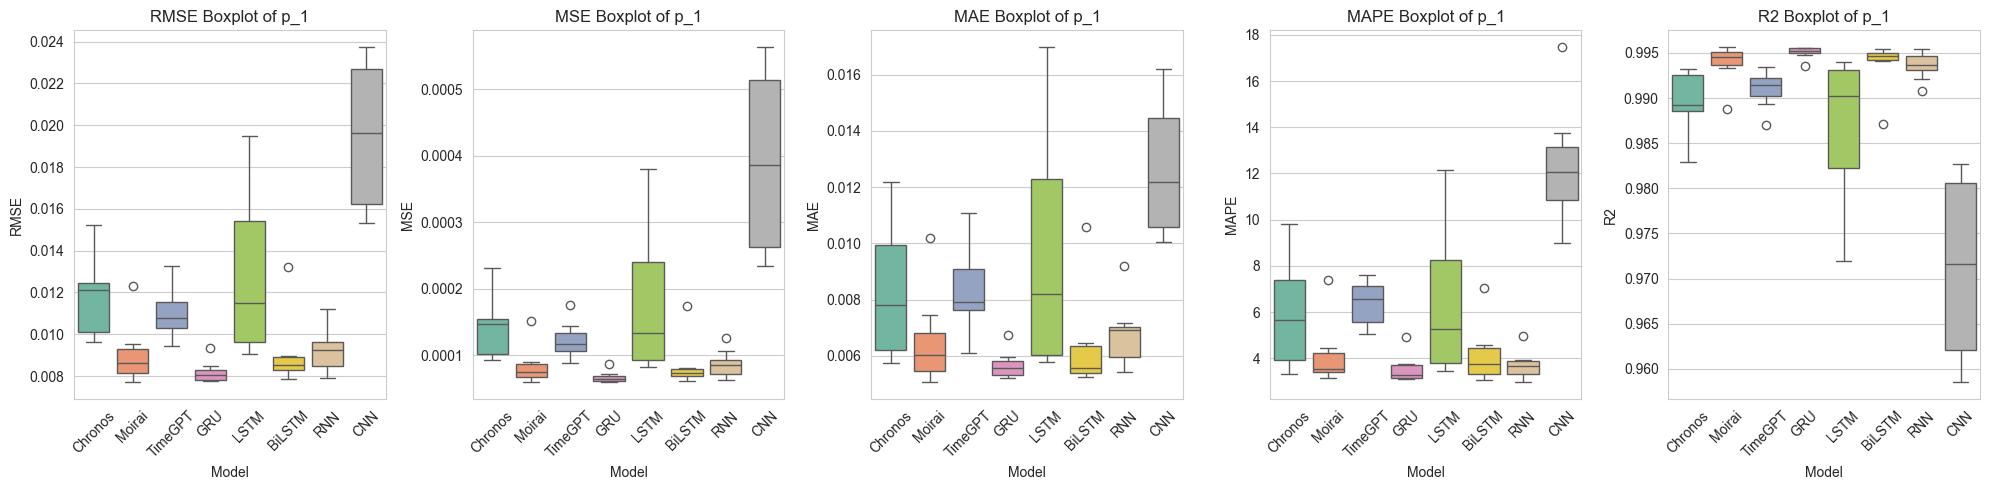

In [ ]:
import os  # Operating system interface for directory operations
import pandas as pd  # Data manipulation and analysis library
import seaborn as sns  # Statistical data visualization library built on matplotlib
import matplotlib.pyplot as plt  # Plotting library for creating static visualizations


# Load the CSV file containing model performance metrics into a pandas DataFrame
df = pd.read_csv("results.csv") #creates results.csv to store the result

# Define a set of column names that must be present in the dataset
required_columns = {'model', 'RMSE', 'MSE', 'MAE', 'MAPE', 'R2'}

# Check if all required columns exist in the loaded DataFrame
# If any required columns are missing, raise an error with details about which columns are missing
if not required_columns.issubset(df.columns):
    raise ValueError(f"Missing required columns: {required_columns - set(df.columns)}")



# Create a directory named "boxplots" to store all generated plot images
plot_dir = "boxplots"
# Create the directory if it doesn't exist, don't raise error if it already exists
os.makedirs(plot_dir, exist_ok=True)

# Set the visual style for seaborn plots to use a white background with grid lines
sns.set_style("whitegrid")



# Create a list of metric column names that will be used for generating boxplots
metrics = ["RMSE", "MSE", "MAE", "MAPE", "R2"]



# Iterate through each metric to create individual boxplot visualizations
for metric in metrics:
    # Create a new figure with specified dimensions (width=6, height=5 inches)
    plt.figure(figsize=(6, 5))
    
    # Create a boxplot with model names on x-axis and current metric values on y-axis
    # Use "Set2" color palette for consistent and appealing colors
    sns.boxplot(x="model", y=metric, data=df, palette="Set2")
    
    # Set the title of the plot using f-string formatting
    plt.title(f"{metric} Boxplot of p_1")
    
    # Label the x-axis to indicate it represents different models
    plt.xlabel("Model")
    
    # Label the y-axis with the current metric name
    plt.ylabel(metric)
    
    # Rotate x-axis labels by 45 degrees to prevent overlapping text
    plt.xticks(rotation=45)
    
    # Save the current plot as a PNG file with high resolution (300 DPI)
    # Use bbox_inches="tight" to ensure all plot elements are included
    plt.savefig(f"{plot_dir}/{metric}_boxplot.png", bbox_inches="tight", dpi=300)
    
    # Close the current figure to free up memory and prevent display issues
    plt.close()


# Create a subplot layout with 1 row and number of columns equal to number of metrics
# Set overall figure size to be wide enough to accommodate all subplots
fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=(20, 5))

# Iterate through metrics with their index positions for subplot creation
for i, metric in enumerate(metrics):
    # Create a boxplot in the i-th subplot position
    # Use the same styling as individual plots for consistency
    sns.boxplot(x="model", y=metric, data=df, ax=axes[i], palette="Set2")
    
    # Set title for each subplot
    axes[i].set_title(f"{metric} Boxplot of p_1")
    
    # Set x-axis label for each subplot
    axes[i].set_xlabel("Model")
    
    # Set y-axis label for each subplot
    axes[i].set_ylabel(metric)
    
    # Rotate x-axis tick labels to prevent overlapping
    axes[i].tick_params(axis="x", rotation=45)


# Automatically adjust subplot parameters to give specified padding
# This prevents overlapping of subplot elements
plt.tight_layout()

# Define the file path for saving the combined boxplot image
combined_plot_path = f"{plot_dir}/all_boxplots_metrics.png"

# Save the entire combined figure as a high-resolution PNG file
plt.savefig(combined_plot_path, bbox_inches="tight", dpi=300)

# Display the combined plot in the output (if running in an interactive environment)
plt.show()


**Model Performance Scatter Plot Generation**

This script generates scatter plots comparing actual vs predicted values for all models, showing both individual plots for each model and a combined comparison view. 

The plots focus on the last iteration results for each model to show final performance.

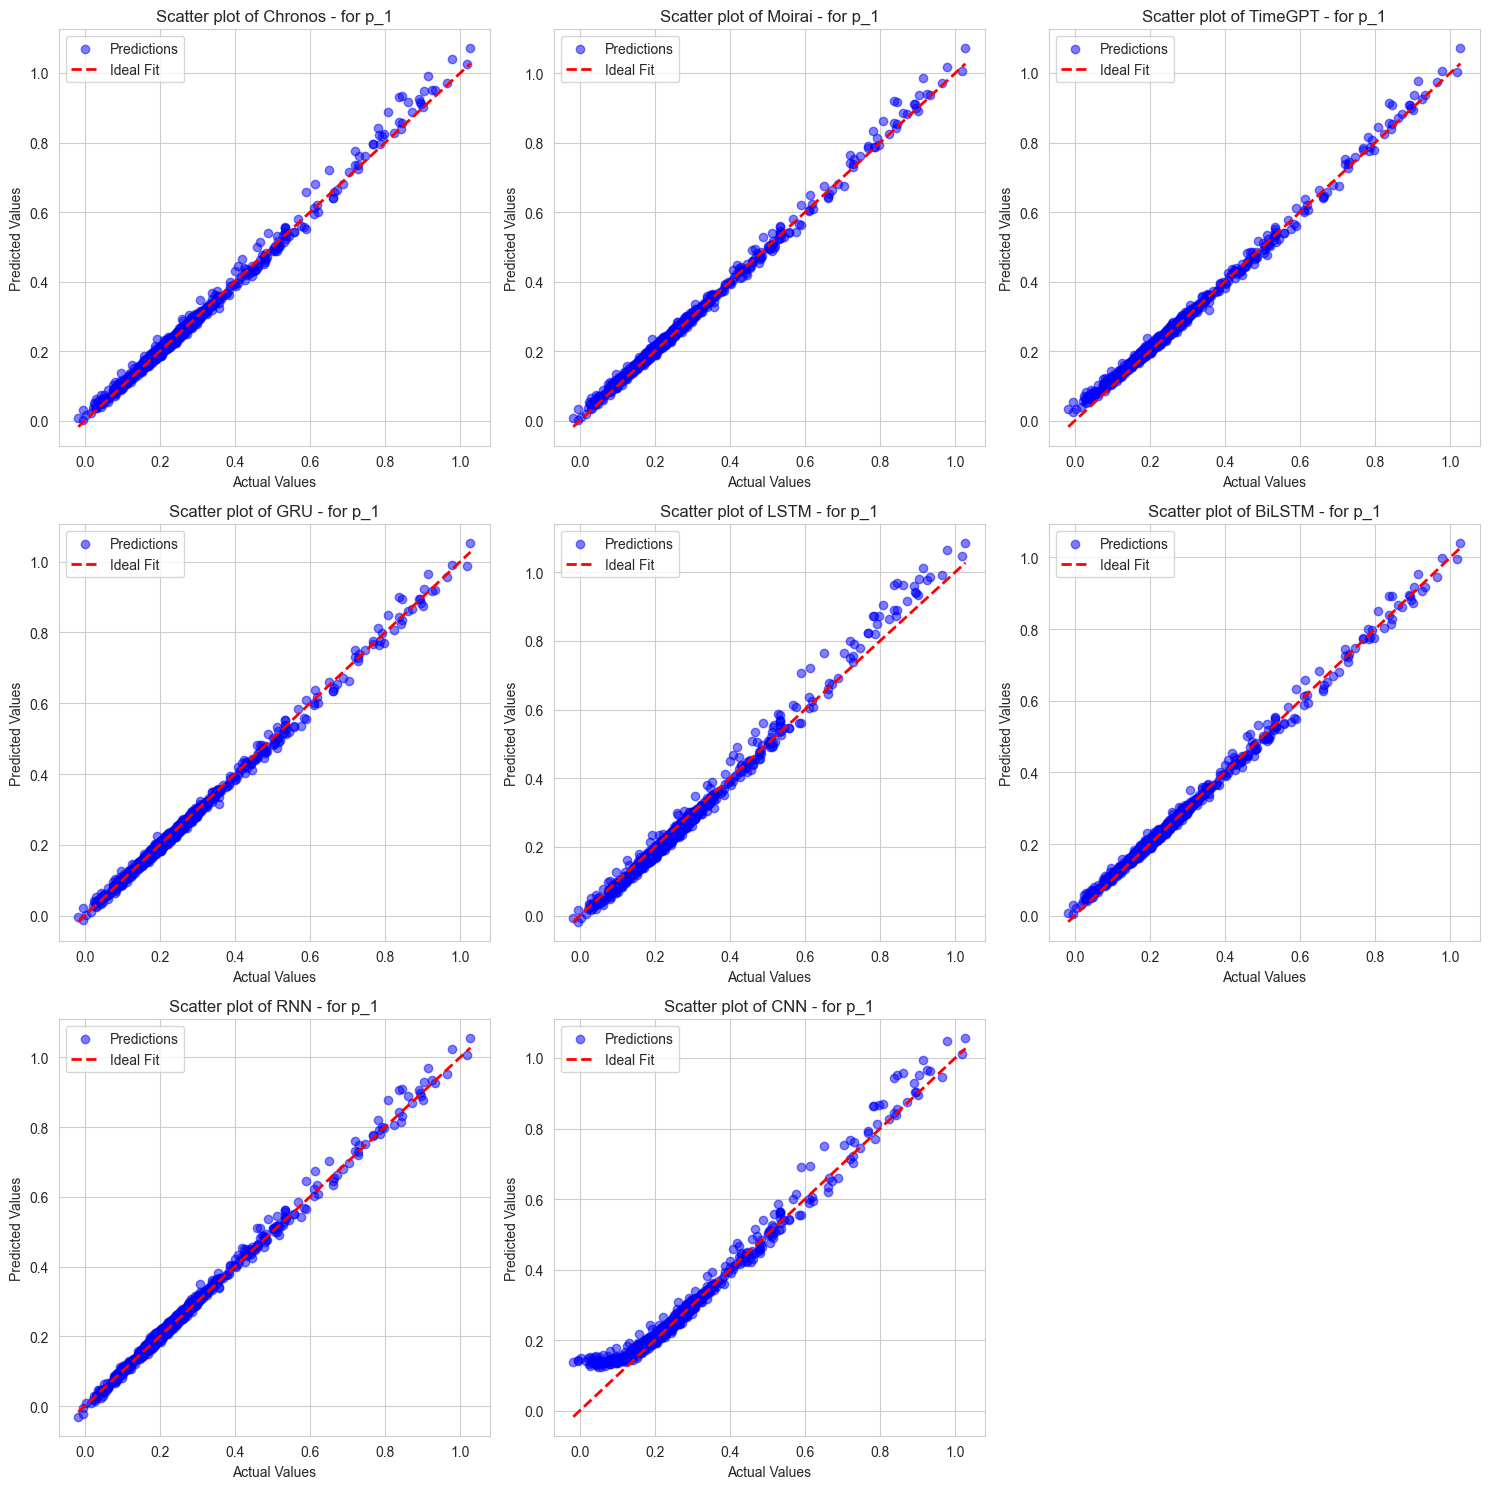

In [ ]:
# Import required libraries for file operations, data manipulation, and plotting
import os  # Operating system interface for file and directory operations
import pandas as pd  # Data manipulation and analysis library for handling CSV files
import matplotlib.pyplot as plt  # Plotting library for creating scatter plot visualizations

# Create main directory structure for organizing scatter plot outputs
plot_dir = "scatter_plots"  # Define main directory name for all scatter plots
os.makedirs(plot_dir, exist_ok=True)  # Create main plot directory, ignore if already exists

# Create subdirectory for individual model scatter plots
individual_plot_dir = os.path.join(plot_dir, "individual")  # Combine path for individual plots subfolder
os.makedirs(individual_plot_dir, exist_ok=True)  # Create individual plots directory, ignore if already exists

# Process results data to find the last iteration for each model
model_last_iteration = {}  # Initialize empty dictionary to store last iteration data for each model

# Iterate through all results to identify the final iteration for each model
for result in results:  # Loop through each result entry in the results collection
    model = result['model']  # Extract model name from current result
    iteration = result['iteration']  # Extract iteration number from current result
    file = result['file']  # Extract file path from current result
    
    # Check if this is the first occurrence of the model or if current iteration is later than stored
    if model not in model_last_iteration or iteration > model_last_iteration[model]['iteration']:
        # Store or update the model's last iteration data with current iteration and file info
        model_last_iteration[model] = {'iteration': iteration, 'file': file}

# Transform the dictionary into a list of tuples for easier plotting iteration
final_results = [(model, data['iteration'], data['file']) for model, data in model_last_iteration.items()]
num_plots = len(final_results)  # Count total number of plots to be generated

# Calculate optimal grid layout for subplot arrangement
cols = 3  # Set number of columns for subplot grid (adjustable based on preference)
rows = (num_plots + cols - 1) // cols  # Calculate required rows using ceiling division

# Create main figure with subplot grid for combined visualization
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 5 * rows))  # Create figure with calculated dimensions
axes = axes.flatten()  # Convert 2D axes array to 1D for easier iteration access

# Generate scatter plots for each model's final iteration results
plot_idx = 0  # Initialize counter for tracking current subplot position

# Iterate through each model's final results to create scatter plots
for model_name, iteration, file_path in final_results:
    # Construct path to the predictions CSV file for current model
    result_file = f"results/{model_name}_{os.path.basename(file_path)}_predictions.csv"
    
    # Skip current model if its predictions file doesn't exist
    if not os.path.exists(result_file):
        continue  # Move to next model without incrementing plot counter
    
    # Load actual and predicted values from the CSV file
    df = pd.read_csv(result_file)  # Read predictions CSV into pandas DataFrame
    actual = df['Actual']  # Extract actual values column as pandas Series
    predicted = df['Predicted']  # Extract predicted values column as pandas Series
    
    # Create scatter plot in the current subplot position
    axes[plot_idx].scatter(actual, predicted, alpha=0.5, color='blue', label='Predictions')  # Plot data points with transparency
    axes[plot_idx].plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2, label='Ideal Fit')  # Add diagonal reference line
    axes[plot_idx].set_xlabel("Actual Values")  # Set x-axis label
    axes[plot_idx].set_ylabel("Predicted Values")  # Set y-axis label
    axes[plot_idx].set_title(f"Scatter plot of {model_name} - for p_1")  # Set subplot title with model name
    axes[plot_idx].legend()  # Add legend to distinguish data points and reference line
    axes[plot_idx].grid(True)  # Enable grid for better readability
    
    # Create and save individual scatter plot for current model
    individual_plot_path = os.path.join(individual_plot_dir, f"{model_name}_last_iteration.png")  # Define individual plot file path
    plt.figure(figsize=(6, 5))  # Create new figure with standard size for individual plot
    plt.scatter(actual, predicted, alpha=0.5, color='blue', label='Predictions')  # Create scatter plot with same styling
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2, label='Ideal Fit')  # Add diagonal reference line
    plt.xlabel("Actual Values")  # Set x-axis label for individual plot
    plt.ylabel("Predicted Values")  # Set y-axis label for individual plot
    plt.title(f"Scatter plot of {model_name} - for p_1")  # Set title for individual plot
    plt.legend()  # Add legend to individual plot
    plt.grid(True)  # Enable grid for individual plot
    plt.savefig(individual_plot_path, bbox_inches="tight", dpi=300)  # Save individual plot with high resolution
    plt.close()  # Close individual plot to free memory and prevent interference
    
    plot_idx += 1  # Increment subplot counter for next iteration

# Clean up unused subplot spaces in the grid
for i in range(plot_idx, len(axes)):  # Loop through remaining unused subplot positions
    fig.delaxes(axes[i])  # Remove unused subplot from the figure

# Finalize and save the combined scatter plot figure
plt.tight_layout()  # Automatically adjust subplot spacing to prevent overlap

# Save the combined scatter plots as a single image file
combined_plot_path = os.path.join(plot_dir, "all_last_iterations_scatter_plots.png")  # Define combined plot file path
plt.savefig(combined_plot_path, bbox_inches="tight", dpi=300)  # Save combined figure with high resolution

# Display the final combined plot (if running in interactive environment)
plt.show()  # Show the completed combined scatter plot visualization

**Model Performance Line Plot Generation**

This script generates line plots comparing actual vs predicted values over data points for machine learning models. 

It creates individual line plots for each model's final iteration and combines them into a single visualization for comprehensive comparison.

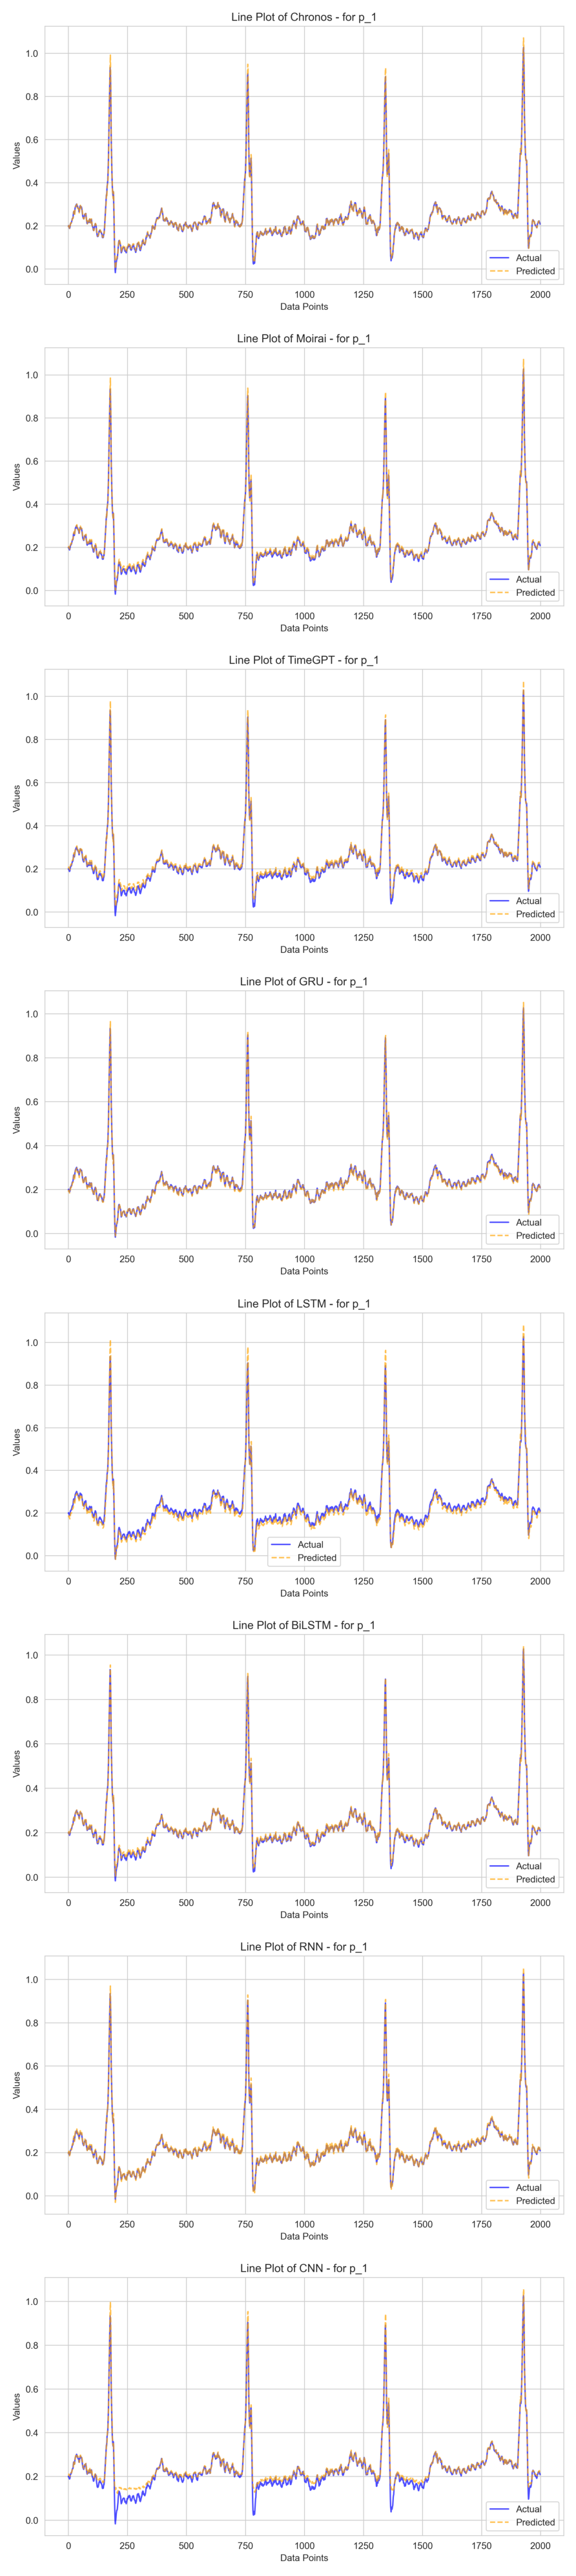

In [ ]:
# Import required libraries for file operations, data manipulation, and plotting
import os  # Operating system interface for file and directory operations
import pandas as pd  # Data manipulation and analysis library for handling CSV files
import matplotlib.pyplot as plt  # Plotting library for creating line plot visualizations

# Create directory structure for organizing line plot outputs
line_plot_dir = "line_plots_orange"  # Define directory name for storing all line plots
os.makedirs(line_plot_dir, exist_ok=True)  # Create line plot directory, ignore if already exists

# Initialize list to store individual plot file paths for later combination
plot_filenames = []  # Empty list to collect file paths of generated individual plots

# Process results data to identify the last iteration for each model
model_last_iteration = {}  # Initialize empty dictionary to store final iteration data per model

# Iterate through all results to find the most recent iteration for each model
for result in results:  # Loop through each result entry in the results collection
    model = result['model']  # Extract model name from current result entry
    iteration = result['iteration']  # Extract iteration number from current result entry
    file = result['file']  # Extract associated file path from current result entry
    
    # Check if this is first occurrence of model or if current iteration is more recent
    if model not in model_last_iteration or iteration > model_last_iteration[model]['iteration']:
        # Store or update the model's most recent iteration data
        model_last_iteration[model] = {'iteration': iteration, 'file': file}

# Generate individual line plots for each model's final iteration results
for model_name, data in model_last_iteration.items():  # Iterate through each model's final iteration data
    iteration = data['iteration']  # Extract iteration number for current model
    file_path = data['file']  # Extract file path for current model
    
    # Construct path to the predictions CSV file for current model
    result_file = f"results/{model_name}_{os.path.basename(file_path)}_predictions.csv"
    
    # Skip current model if its predictions file doesn't exist
    if not os.path.exists(result_file):
        continue  # Move to next model without creating plot
    
    # Load actual and predicted values from the CSV file
    df = pd.read_csv(result_file)  # Read predictions CSV into pandas DataFrame
    actual = df['Actual']  # Extract actual values column as pandas Series
    predicted = df['Predicted']  # Extract predicted values column as pandas Series
    
    # Create line plot visualization for current model
    plt.figure(figsize=(10, 5))  # Create new figure with specified dimensions
    
    # Plot actual values as solid blue line with transparency
    plt.plot(range(len(actual)), actual, label="Actual", linestyle='-', color='blue', alpha=0.7)
    
    # Plot predicted values as dashed orange line with transparency
    plt.plot(range(len(predicted)), predicted, label="Predicted", linestyle='--', color='orange', alpha=0.7)
    
    # Set axis labels and plot title
    plt.xlabel("Data Points")  # Label x-axis to indicate data point indices
    plt.ylabel("Values")  # Label y-axis to indicate actual/predicted values
    plt.title(f"Line Plot of {model_name} - for p_1")  # Set descriptive title with model name
    
    # Add legend and grid for better readability
    plt.legend()  # Display legend to distinguish actual vs predicted lines
    plt.grid(True)  # Enable grid for easier value reading
    
    # Save the individual line plot with high resolution
    plot_filename = f"{line_plot_dir}/{model_name}_last_iteration.png"  # Define file path for current plot
    plt.savefig(plot_filename, bbox_inches="tight", dpi=300)  # Save plot with tight bounding box and high DPI
    plot_filenames.append(plot_filename)  # Add file path to list for later combination
    plt.close()  # Close current figure to free memory and prevent display interference

# Create combined visualization containing all individual line plots
if plot_filenames:  # Proceed only if at least one plot was successfully generated
    # Create subplot layout with one column and rows equal to number of plots
    fig, axes = plt.subplots(nrows=len(plot_filenames), ncols=1, figsize=(10, 5 * len(plot_filenames)))
    
    # Handle case where only one plot exists (axes needs to be iterable)
    if len(plot_filenames) == 1:
        axes = [axes]  # Convert single axis to list for consistent iteration
    
    # Display each saved plot image in the combined figure
    for ax, plot_filename in zip(axes, plot_filenames):  # Iterate through axes and corresponding plot files
        img = plt.imread(plot_filename)  # Read saved plot image as array
        ax.imshow(img)  # Display image in current subplot
        ax.axis("off")  # Hide axis ticks and labels for cleaner appearance
    
    # Finalize and save the combined line plot figure
    plt.tight_layout()  # Automatically adjust subplot spacing to prevent overlap
    combined_plot_path = f"{line_plot_dir}/all_last_iterations_line_plots.png"  # Define combined plot file path
    plt.savefig(combined_plot_path, bbox_inches="tight", dpi=300)  # Save combined figure with high resolution
    plt.show()  # Display the completed combined line plot visualization